In [2]:
%cd ..

/Users/juansegundohevia/Documents/repos/TexTract


In [3]:
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import pickle as pkl
from PIL import Image
import json

# Combine lines in images

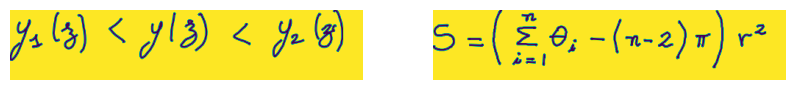

In [8]:
sample_img1 = Image.open('notebooks/sample_images/sample_image1.png')
sample_img2 = Image.open('notebooks/sample_images/sample_image2.png')

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(sample_img1)
ax[1].imshow(sample_img2)
# remove axis
for a in ax:
    a.axis('off')
    


In [9]:
img1_arr = np.array(sample_img1)
img2_arr = np.array(sample_img2)

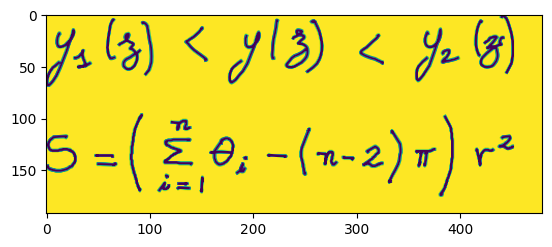

In [10]:
stacked = np.vstack([img1_arr, img2_arr])
plt.imshow(stacked)

In [11]:
def add_padding(img, padding_scale=0.05):
    """
    Add padding relative to the image size, scaling 
    with the padding_scale factor.
    """
    padding = int(padding_scale * img.shape[0])
    return np.pad(img, ((padding, padding), (padding, padding)), mode='constant', constant_values=255)

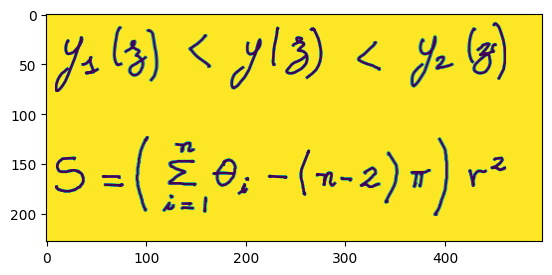

In [12]:
pad_scale = 0.1
img1_arr_padded = add_padding(img1_arr, padding_scale=pad_scale)
img2_arr_padded = add_padding(img2_arr, padding_scale=pad_scale)
stacked = np.vstack([img1_arr_padded, img2_arr_padded])
plt.imshow(stacked)

### Check more images

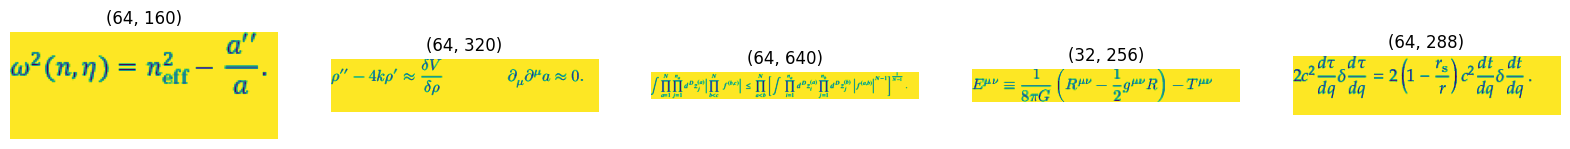

In [13]:
img_arr = [Image.open(os.path.join('pix2tex/dataset/formulae/train/', f)) for f in os.listdir('pix2tex/dataset/formulae/train')[:5]]

fig ,ax = plt.subplots(1, 5, figsize=(20, 5))

for i, img in enumerate(img_arr):
    ax[i].imshow(img)
    ax[i].axis('off')
    # set title with image shape
    ax[i].set_title(np.array(img).shape)

Max height: 64, Max width: 640
Padding height: 0, Padding width: 288


Text(0.5, 1.0, '(64, 160)')

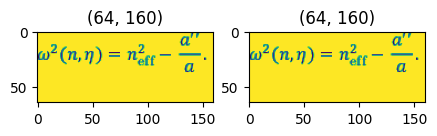

In [14]:
max_h = np.max([img.size[1] for img in img_arr])
max_w = np.max([img.size[0] for img in img_arr])

print(f'Max height: {max_h}, Max width: {max_w}')
# pad to keep aspect ratios (image 0 should have a larger width i.e.)
target_img = img_arr[0]
pad_h = np.max([(max_h - target_img.size[0]) // 2, 0])
pad_w = np.max([(max_w - target_img.size[1]) // 2, 0])
print(f'Padding height: {pad_h}, Padding width: {pad_w}')

target_img_padded = np.pad(np.array(target_img), ((0,0), (0,0)), mode='constant', constant_values=255)

fig ,ax = plt.subplots(1, 2, figsize=(5, 5))
ax[0].imshow(target_img)
ax[1].imshow(target_img_padded)
ax[0].set_title(np.array(target_img).shape)
ax[1].set_title(target_img_padded.shape)

In [15]:
def pad_both_sides(img, target_h, target_w) -> np.ndarray:
    """
    Pad an image to the target height and width on both sides.
    """
    if isinstance(img, Image.Image):
        img = np.array(img)
    assert isinstance(img, np.ndarray), f"Type is {type(img)}, expected np.ndarray."

    pad_h = (target_h - img.shape[0]) // 2
    pad_w = (target_w - img.shape[1]) // 2

    pad_h = np.max([0, pad_h])
    pad_w = np.max([0, pad_w])

    return np.pad(img, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant', constant_values=255)

def convert_to_homog_shape(img_arr):
    """
    Compute the maximum height and width of the images in the list
    and pad the images to the maximum height and width.
    """
    max_h = np.max([np.array(img).shape[0] for img in img_arr])
    max_w = np.max([np.array(img).shape[1] for img in img_arr])
    img_arr_padded = [pad_both_sides(img, max_h, max_w) for img in img_arr]
    return img_arr_padded

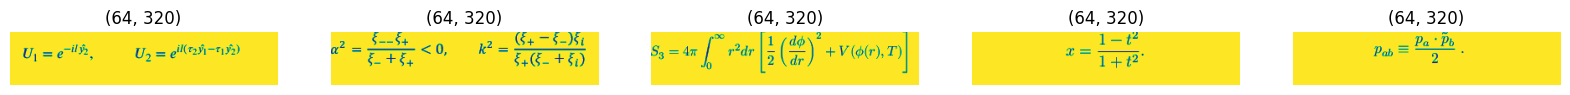

In [16]:
img_arr = [Image.open(os.path.join('pix2tex/dataset/formulae/train/', f)) for f in os.listdir('pix2tex/dataset/formulae/train')[5:10]]
img_arr = convert_to_homog_shape(img_arr)
fig ,ax = plt.subplots(1, 5, figsize=(20, 5))

for i, img in enumerate(img_arr):
    ax[i].imshow(img)
    ax[i].axis('off')
    # set title with image shape
    ax[i].set_title(img.shape)

In [17]:
type(img)
img.shape

(64, 320)

In [18]:
def combine_images(img_arr, padding_scale=0.05):
    """
    Combine images in a list to a single image with padding.
    """
    img_arr_padded = convert_to_homog_shape(img_arr)
    return np.vstack(img_arr_padded)

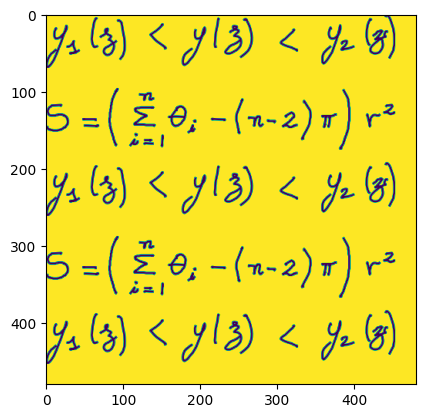

In [19]:
# repeat the process for 5 images
img_arr = [img1_arr, img2_arr, img1_arr, img2_arr, img1_arr]
stacked = combine_images(img_arr, padding_scale=pad_scale)
plt.imshow(stacked)

In [20]:
img1_arr.shape, img2_arr.shape

((96, 480), (96, 480))

In [21]:
stacked.shape

(480, 480)

## Combine text labels

In [22]:
with open('pix2tex/dataset/formulae/math.txt', 'r') as f:
    formulae = f.readlines()
# strip the newline character
formulae = [f.strip() for f in formulae]

formulae[0]

'\\int _ { - \\epsilon } ^ { \\infty } d l \\: \\mathrm { e } ^ { - l \\zeta } \\int _ { - \\epsilon } ^ { \\infty } d l ^ { \\prime } \\mathrm { e } ^ { - l ^ { \\prime } \\zeta } l l ^ { \\prime } { \\frac { l ^ { \\prime } - l } { l + l ^ { \\prime } } } \\{ 3 \\, \\delta ^ { \\prime \\prime } ( l ) - { \\frac { 3 } { 4 } } t \\, \\delta ( l ) \\} = 0 .'

In [23]:
def get_formula_idx(img_name):
    """
    Get the formula index from the image name.
    """
    return int(os.path.basename(img_name).split('.')[0])

get_formula_idx('notebooks/sample_images/00000001.png')

1

In [24]:
def remove_trailing_dots(s):
    """
    Given an input string, remove any trailing dots at the end
    of the sequence
    """
    return s.rstrip('.')

In [25]:
t1 = 'notebooks/sample_images/000001.png'
t2 = 'notebooks/sample_images/000002.png'

label1 = formulae[get_formula_idx(t1)]
label2 = formulae[get_formula_idx(t2)]

labels = [remove_trailing_dots(l) for l in [label1, label2]]

combined_labels = ' \\\\ '.join(labels)
print(combined_labels)

d s ^ { 2 } = ( 1 - { \frac { q c o s \theta } { r } } ) ^ { \frac { 2 } { 1 + \alpha ^ { 2 } } } \lbrace d r ^ { 2 } + r ^ { 2 } d \theta ^ { 2 } + r ^ { 2 } s i n ^ { 2 } \theta d \varphi ^ { 2 } \rbrace - { \frac { d t ^ { 2 } } { ( 1 - { \frac { q c o s \theta } { r } } ) ^ { \frac { 2 } { 1 + \alpha ^ { 2 } } } } } \,  \\ \widetilde \gamma _ { \mathrm { h o p f } } \simeq \sum _ { n > 0 } \widetilde { G } _ { n } { \frac { ( - a ) ^ { n } } { 2 ^ { 2 n - 1 } } }


$$d s ^ { 2 } = ( 1 - { \frac { q c o s \theta } { r } } ) ^ { \frac { 2 } { 1 + \alpha ^ { 2 } } } \lbrace d r ^ { 2 } + r ^ { 2 } d \theta ^ { 2 } + r ^ { 2 } s i n ^ { 2 } \theta d \varphi ^ { 2 } \rbrace - { \frac { d t ^ { 2 } } { ( 1 - { \frac { q c o s \theta } { r } } ) ^ { \frac { 2 } { 1 + \alpha ^ { 2 } } } } } \,  \\ \widetilde \gamma _ { \mathrm { h o p f } } \simeq \sum _ { n > 0 } \widetilde { G } _ { n } { \frac { ( - a ) ^ { n } } { 2 ^ { 2 n - 1 } } }$$

In [26]:
def combine_labels(fnames_arr):
    """
    Combine labels in a list to a single string with 
    a newline character between each label.
    """
    labels_arr = [formulae[get_formula_idx(f)] for f in fnames_arr]
    return ' \\\\ '.join([remove_trailing_dots(l) for l in labels_arr])

## Final fn

In [27]:
def merge_images_and_labels(fnames_arr, padding_scale=0.05):
    """
    Combine images in a list to a single image with padding
    and combine the labels to a single string with a newline
    character between each label.
    """
    img_arr = [np.array(Image.open(f)) for f in fnames_arr]
    img_arr = convert_to_homog_shape(img_arr)
    stacked = combine_images(img_arr, padding_scale)
    labels = combine_labels(fnames_arr)
    return stacked, labels

# test

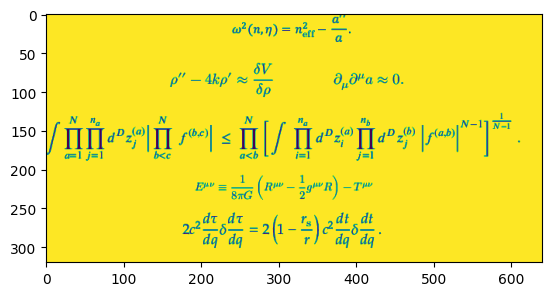

In [28]:
TRAIN_PATH = "pix2tex/dataset/formulae/train/"

# get the first 5 images in the training set
train_fnames = [os.path.join(TRAIN_PATH, f) for f in os.listdir(TRAIN_PATH)[:5]]

stacked, labels = merge_images_and_labels(train_fnames, padding_scale=0.2)
plt.imshow(stacked)

In [29]:
print(labels)

\omega ^ { 2 } ( n , \eta ) = n _ { \mathrm { e f f } } ^ { 2 } - \frac { a ^ { \prime \prime } } { a }  \\ \rho ^ { \prime \prime } - 4 k \rho ^ { \prime } \approx { \frac { \delta V } { \delta \rho } } \qquad \qquad \partial _ { \mu } \partial ^ { \mu } a \approx 0  \\ \int \prod _ { a = 1 } ^ { N } \prod _ { j = 1 } ^ { n _ { a } } d ^ { D } z _ { j } ^ { ( a ) } \bigg | \prod _ { b < c } ^ { N } \; f ^ { ( b , c ) } \bigg | \; \leq \; \prod _ { a < b } ^ { N } \Bigg [ \int \; \prod _ { i = 1 } ^ { n _ { a } } d ^ { D } z _ { i } ^ { ( a ) } \prod _ { j = 1 } ^ { n _ { b } } d ^ { D } z _ { j } ^ { ( b ) } \; \bigg | f ^ { ( a , b ) } \bigg | ^ { N - 1 } \Bigg ] ^ { \frac { 1 } { N - 1 } } \;  \\ E ^ { \mu \nu } \equiv \frac { 1 } { 8 \pi G } \left( R ^ { \mu \nu } - \frac { 1 } { 2 } g ^ { \mu \nu } R \right) - T ^ { \mu \nu } \\ 2 c ^ { 2 } { \frac { d \tau } { d q } } \delta { \frac { d \tau } { d q } } = 2 \left( 1 - { \frac { r _ { \mathrm { { s } } } } { r } } \right) c ^ { 2 

$$
\omega ^ { 2 } ( n , \eta ) = n _ { \mathrm { e f f } } ^ { 2 } - \frac { a ^ { \prime \prime } } { a }  \\ \rho ^ { \prime \prime } - 4 k \rho ^ { \prime } \approx { \frac { \delta V } { \delta \rho } } \qquad \qquad \partial _ { \mu } \partial ^ { \mu } a \approx 0  \\ \int \prod _ { a = 1 } ^ { N } \prod _ { j = 1 } ^ { n _ { a } } d ^ { D } z _ { j } ^ { ( a ) } \bigg | \prod _ { b < c } ^ { N } \; f ^ { ( b , c ) } \bigg | \; \leq \; \prod _ { a < b } ^ { N } \Bigg [ \int \; \prod _ { i = 1 } ^ { n _ { a } } d ^ { D } z _ { i } ^ { ( a ) } \prod _ { j = 1 } ^ { n _ { b } } d ^ { D } z _ { j } ^ { ( b ) } \; \bigg | f ^ { ( a , b ) } \bigg | ^ { N - 1 } \Bigg ] ^ { \frac { 1 } { N - 1 } } \;  \\ E ^ { \mu \nu } \equiv \frac { 1 } { 8 \pi G } \left( R ^ { \mu \nu } - \frac { 1 } { 2 } g ^ { \mu \nu } R \right) - T ^ { \mu \nu } \\ 2 c ^ { 2 } { \frac { d \tau } { d q } } \delta { \frac { d \tau } { d q } } = 2 \left( 1 - { \frac { r _ { \mathrm { { s } } } } { r } } \right) c ^ { 2 } { \frac { d t } { d q } } \delta { \frac { d t } { d q } } \, 
$$

# Build concat dataset

## train

In [44]:
TRAIN_PATH = "pix2tex/dataset/formulae/train/"

fnames = [os.path.join(TRAIN_PATH, f) for f in os.listdir(TRAIN_PATH)]

pockets = []

# build pockets of a random number of images, from 2 to 5
while len(fnames) > 0:
    n = np.random.randint(2, 6)
    pocket = fnames[:n]
    pockets.append(pocket)
    fnames = fnames[n:].copy()

In [45]:
'_'.join([pn.split("/")[-1].split(".")[0] for pn in pocket])


'0141087_0215308_0179518_0074996_0202674'

In [46]:
len(os.listdir(TRAIN_PATH))

158480

In [47]:
len(pockets)

45240

In [60]:
from tqdm import tqdm
PADDING_SCALE = 0.2
MULTILINE_DATA_PATH = "pix2tex/dataset/multiline"
# create "train" folder under the multiline data path

if not os.path.exists(os.path.join(MULTILINE_DATA_PATH, "train")):
    os.makedirs(os.path.join(MULTILINE_DATA_PATH, "train"), exist_ok=True)

labels_all = []

merged_image_idx_mapping = {}
file_idx = 0
for pocket in tqdm(pockets):
    try:
        merged_image, label = merge_images_and_labels(pocket, padding_scale=PADDING_SCALE)
    except:
        continue
    
    # build fname for the pocket
    merged_image_filenames = '_'.join([pn.split("/")[-1].split(".")[0] for pn in pocket])
    merged_image_idx_mapping[file_idx] = merged_image_filenames

    # save the image
    img = Image.fromarray(merged_image)
    img.save(os.path.join(MULTILINE_DATA_PATH, "train", f"{file_idx}.png"))
    labels_all.append(label)
    file_idx += 1
    

100%|██████████| 45240/45240 [02:36<00:00, 289.23it/s]


In [61]:
len(os.listdir(os.path.join(MULTILINE_DATA_PATH, "train")))

45117

In [62]:
len(labels_all)

45117

In [63]:
labels_all[0]

'\\omega ^ { 2 } ( n , \\eta ) = n _ { \\mathrm { e f f } } ^ { 2 } - \\frac { a ^ { \\prime \\prime } } { a }  \\\\ \\rho ^ { \\prime \\prime } - 4 k \\rho ^ { \\prime } \\approx { \\frac { \\delta V } { \\delta \\rho } } \\qquad \\qquad \\partial _ { \\mu } \\partial ^ { \\mu } a \\approx 0 '

In [64]:
MULTILINE_DATA_PATH = "pix2tex/dataset/multiline"

# write labels to a txt file
with open(os.path.join(MULTILINE_DATA_PATH, "train_labels.txt"), 'w') as f:
    for label in labels_all:
        f.write(label + '\n')

In [65]:
# save mappign for tracking the image names
import json

with open(os.path.join(MULTILINE_DATA_PATH, "train_merged_image_idx_mapping.json"), 'w') as f:
    json.dump(merged_image_idx_mapping, f)

## val

In [23]:
VAL_PATH = "pix2tex/dataset/formulae/val/"

fnames = [os.path.join(VAL_PATH, f) for f in os.listdir(VAL_PATH)]

pockets = []

# build pockets of a random number of images, from 2 to 5
while len(fnames) > 0:
    n = np.random.randint(2, 6)
    pocket = fnames[:n]
    pockets.append(pocket)
    fnames = fnames[n:].copy()

In [24]:
'_'.join([pn.split("/")[-1].split(".")[0] for pn in pocket])


'0061419_0131206_0206412_0082966_0089833'

In [25]:
len(os.listdir(VAL_PATH))

6765

In [26]:
len(pockets)

1938

In [27]:
from tqdm import tqdm
PADDING_SCALE = 0.2
MULTILINE_DATA_PATH = "pix2tex/dataset/multiline"
# create "train" folder under the multiline data path

if not os.path.exists(os.path.join(MULTILINE_DATA_PATH, "val")):
    os.makedirs(os.path.join(MULTILINE_DATA_PATH, "val"), exist_ok=True)

labels_all = []

merged_image_idx_mapping = {}
file_idx = 0
for pocket in tqdm(pockets):
    try:
        merged_image, label = merge_images_and_labels(pocket, padding_scale=PADDING_SCALE)
    except:
        continue
    
    # build fname for the pocket
    merged_image_filenames = '_'.join([pn.split("/")[-1].split(".")[0] for pn in pocket])
    merged_image_idx_mapping[file_idx] = merged_image_filenames

    # save the image
    img = Image.fromarray(merged_image)
    img.save(os.path.join(MULTILINE_DATA_PATH, "val", f"{file_idx}.png"))
    labels_all.append(label)
    file_idx += 1
    

  0%|          | 0/1938 [00:00<?, ?it/s]

100%|██████████| 1938/1938 [00:06<00:00, 293.49it/s]


In [28]:
len(os.listdir(os.path.join(MULTILINE_DATA_PATH, "val")))

1935

In [29]:
len(labels_all)

1935

In [30]:
# write labels to a txt file
with open(os.path.join(MULTILINE_DATA_PATH, "val_labels.txt"), 'w') as f:
    for label in labels_all:
        f.write(label + '\n')

In [32]:
import json

# save mappign for tracking the image names
with open(os.path.join(MULTILINE_DATA_PATH, "val_merged_image_idx_mapping.json"), 'w') as f:
    json.dump(merged_image_idx_mapping, f)

## Test

In [30]:
TEST_PATH = "pix2tex/dataset/formulae/test/"

fnames = [os.path.join(TEST_PATH, f) for f in os.listdir(TEST_PATH)]

pockets = []

# build pockets of a random number of images, from 2 to 5
while len(fnames) > 0:
    n = np.random.randint(2, 6)
    pocket = fnames[:n]
    pockets.append(pocket)
    fnames = fnames[n:].copy()

In [31]:
'_'.join([pn.split("/")[-1].split(".")[0] for pn in pocket])


'0161357_0023616_0127302'

In [32]:
len(os.listdir(TEST_PATH))

30637

In [33]:
len(pockets)

8685

In [34]:
# pick only fist 1000 pockets for testings
pockets = pockets[:1000]

In [35]:
# pick only fist 1000 pockets for testings
pockets_300 = pockets[:300]

In [30]:
from tqdm import tqdm
PADDING_SCALE = 0.2
MULTILINE_DATA_PATH = "pix2tex/dataset/multiline"
# create "train" folder under the multiline data path

if not os.path.exists(os.path.join(MULTILINE_DATA_PATH, "test")):
    os.makedirs(os.path.join(MULTILINE_DATA_PATH, "test"), exist_ok=True)

labels_all = []

merged_image_idx_mapping = {}
file_idx = 0
for pocket in tqdm(pockets):
    try:
        merged_image, label = merge_images_and_labels(pocket, padding_scale=PADDING_SCALE)
    except:
        continue
    
    # build fname for the pocket
    merged_image_filenames = '_'.join([pn.split("/")[-1].split(".")[0] for pn in pocket])
    merged_image_idx_mapping[file_idx] = merged_image_filenames

    # save the image
    img = Image.fromarray(merged_image)
    img.save(os.path.join(MULTILINE_DATA_PATH, "test", f"{file_idx}.png"))
    labels_all.append(label)
    file_idx += 1
    
len(os.listdir(os.path.join(MULTILINE_DATA_PATH, "test")))
len(labels_all)
# write labels to a txt file
with open(os.path.join(MULTILINE_DATA_PATH, "test_labels.txt"), 'w') as f:
    for label in labels_all:
        f.write(label + '\n')
import json
# save mappign for tracking the image names
with open(os.path.join(MULTILINE_DATA_PATH, "test_merged_image_idx_mapping.json"), 'w') as f:
    json.dump(merged_image_idx_mapping, f)

100%|██████████| 1000/1000 [00:07<00:00, 128.93it/s]


# Work with pockets_300

In [36]:
from tqdm import tqdm
PADDING_SCALE = 0.2
MULTILINE_DATA_PATH = "pix2tex/dataset/multiline"
# create "train" folder under the multiline data path

if not os.path.exists(os.path.join(MULTILINE_DATA_PATH, "test_300")):
    os.makedirs(os.path.join(MULTILINE_DATA_PATH, "test_300"), exist_ok=True)

labels_all = []

merged_image_idx_mapping = {}
file_idx = 0
for pocket in tqdm(pockets_300):
    try:
        merged_image, label = merge_images_and_labels(pocket, padding_scale=PADDING_SCALE)
    except:
        continue
    
    # build fname for the pocket
    merged_image_filenames = '_'.join([pn.split("/")[-1].split(".")[0] for pn in pocket])
    merged_image_idx_mapping[file_idx] = merged_image_filenames

    # save the image
    img = Image.fromarray(merged_image)
    img.save(os.path.join(MULTILINE_DATA_PATH, "test_300", f"{file_idx}.png"))
    labels_all.append(label)
    file_idx += 1
    
len(os.listdir(os.path.join(MULTILINE_DATA_PATH, "test_300")))
len(labels_all)
# write labels to a txt file
with open(os.path.join(MULTILINE_DATA_PATH, "test_300_labels.txt"), 'w') as f:
    for label in labels_all:
        f.write(label + '\n')
import json
# save mappign for tracking the image names
with open(os.path.join(MULTILINE_DATA_PATH, "test_300_merged_image_idx_mapping.json"), 'w') as f:
    json.dump(merged_image_idx_mapping, f)

100%|██████████| 300/300 [00:01<00:00, 168.01it/s]


## Test short

In [47]:
TEST_PATH = "pix2tex/dataset/formulae/test/"

fnames = [os.path.join(TEST_PATH, f) for f in os.listdir(TEST_PATH)]

pockets = []

# build pockets of a random number of images, from 2 to 5
while len(fnames) > 0:
    n = np.random.randint(2, 6)
    pocket = fnames[:n]
    pockets.append(pocket)
    fnames = fnames[n:].copy()

In [48]:
'_'.join([pn.split("/")[-1].split(".")[0] for pn in pocket])


'0023616_0127302'

In [49]:
len(os.listdir(TEST_PATH))

30637

In [50]:
len(pockets)

8768

In [51]:
# pick only fist 30 pockets for testings
pockets = pockets[:40]

In [52]:
from tqdm import tqdm
PADDING_SCALE = 0.2
MULTILINE_DATA_PATH = "pix2tex/dataset/multiline"
# create "train" folder under the multiline data path

if not os.path.exists(os.path.join(MULTILINE_DATA_PATH, "test_short")):
    os.makedirs(os.path.join(MULTILINE_DATA_PATH, "test_short"), exist_ok=True)

labels_all = []

merged_image_idx_mapping = {}
file_idx = 0
for pocket in tqdm(pockets):
    try:
        merged_image, label = merge_images_and_labels(pocket, padding_scale=PADDING_SCALE)
    except:
        continue
    
    # build fname for the pocket
    merged_image_filenames = '_'.join([pn.split("/")[-1].split(".")[0] for pn in pocket])
    merged_image_idx_mapping[file_idx] = merged_image_filenames

    # save the image
    img = Image.fromarray(merged_image)
    img.save(os.path.join(MULTILINE_DATA_PATH, "test_short", f"{file_idx}.png"))
    labels_all.append(label)
    file_idx += 1
    

100%|██████████| 40/40 [00:00<00:00, 152.11it/s]


In [53]:
len(os.listdir(os.path.join(MULTILINE_DATA_PATH, "test_short")))

40

In [54]:
len(labels_all)

40

In [55]:
# write labels to a txt file
with open(os.path.join(MULTILINE_DATA_PATH, "test_labels_short.txt"), 'w') as f:
    for label in labels_all:
        f.write(label + '\n')

In [56]:
import json

In [57]:
# save mappign for tracking the image names
with open(os.path.join(MULTILINE_DATA_PATH, "tes_short_merged_image_idx_mapping.json"), 'w') as f:
    json.dump(merged_image_idx_mapping, f)